In [1]:
!pip install -U 'scikit-learn<0.24'


     |████████████████████████████████| 6.8 MB 5.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [2]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 965 kB 5.4 MB/s 


In [3]:
!pip install eli5

     |████████████████████████████████| 106 kB 5.5 MB/s 


In [4]:
import numpy as np
import pandas as pd
from pandas.core.groupby.base import OutputKey
from sklearn.feature_extraction import DictVectorizer
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from tqdm import tqdm
import json
import eli5

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **AQMAR**

In [26]:
data= pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Aqmar.csv')
data

,Words,Sentence #
0,العصر B-MIS1,1.0
1,الذهبي I-MIS1,NaN
2,للإسلام O,NaN
3,تمتد O,NaN
4,لغاية O,NaN
...,...,...
71742,الهامة O,NaN
71743,في O,NaN
71744,تاريخ O,NaN
71745,الجامع O,NaN


In [27]:
data[['A', 'B']] = data['Words'].str.split(' ', 1, expand=True)
data

,Words,Sentence #,A,B
0,العصر B-MIS1,1.0,العصر,B-MIS1
1,الذهبي I-MIS1,NaN,الذهبي,I-MIS1
2,للإسلام O,NaN,للإسلام,O
3,تمتد O,NaN,تمتد,O
4,لغاية O,NaN,لغاية,O
...,...,...,...,...
71742,الهامة O,NaN,الهامة,O
71743,في O,NaN,في,O
71744,تاريخ O,NaN,تاريخ,O
71745,الجامع O,NaN,الجامع,O


In [28]:
data = data.drop(columns=['Words']) # remove last column 

In [29]:
data = data.rename(columns={"B": "Tag", "A": "Word"}) # rename columns name
data.head()
data

,Sentence #,Word,Tag
0,1.0,العصر,B-MIS1
1,NaN,الذهبي,I-MIS1
2,NaN,للإسلام,O
3,NaN,تمتد,O
4,NaN,لغاية,O
...,...,...,...
71742,NaN,الهامة,O
71743,NaN,في,O
71744,NaN,تاريخ,O
71745,NaN,الجامع,O


In [30]:
data.groupby('Tag').size().reset_index(name='counts')


,Tag,counts
0,B-ENGLISH,1
1,B-LOC,1355
2,B-MIS,3
3,B-MIS-1,2
4,B-MIS-2,1
5,B-MIS0,155
6,B-MIS1,1466
7,B-MIS2,413
8,B-MIS3,125
9,B-MISS1,1


In [31]:
data['Tag'] = data['Tag'].replace(['B-MIS-1'],'B-MIS')
data['Tag'] = data['Tag'].replace(['B-MIS-2'],'B-MIS')
data['Tag'] = data['Tag'].replace(['B-MIS0'],'B-MIS')
data['Tag'] = data['Tag'].replace(['B-MIS1'],'B-MIS')
data['Tag'] = data['Tag'].replace(['B-MIS2'],'B-MIS')
data['Tag'] = data['Tag'].replace(['B-MIS3'],'B-MIS')
data['Tag'] = data['Tag'].replace(['B-MISS1'],'B-MIS')
data['Tag'] = data['Tag'].replace(['I--ORG'],'I-ORG')
data['Tag'] = data['Tag'].replace(['I-MIS0'],'I-MIS')
data['Tag'] = data['Tag'].replace(['I-MIS1'],'I-MIS')
data['Tag'] = data['Tag'].replace(['I-MIS2'],'I-MIS')
data['Tag'] = data['Tag'].replace(['I-MIS3'],'I-MIS')
data['Tag'] = data['Tag'].replace(['IO'],'O')
data['Tag'] = data['Tag'].replace(['O"'],'O')
data['Tag'] = data['Tag'].replace(['OO'],'O')
data['Tag'] = data['Tag'].replace(['B-ENGLISH'],'O')
data['Tag'] = data['Tag'].replace(['B-SPANISH'],'O')


In [32]:
data.groupby('Tag').size().reset_index(name='counts')


,Tag,counts
0,B-LOC,1355
1,B-MIS,2166
2,B-ORG,427
3,B-PER,1430
4,I-LOC,576
5,I-MIS,1289
6,I-ORG,467
7,I-PER,904
8,O,60334


In [33]:
data

,Sentence #,Word,Tag
0,1.0,العصر,B-MIS
1,NaN,الذهبي,I-MIS
2,NaN,للإسلام,O
3,NaN,تمتد,O
4,NaN,لغاية,O
...,...,...,...
71742,NaN,الهامة,O
71743,NaN,في,O
71744,NaN,تاريخ,O
71745,NaN,الجامع,O


In [34]:
# to number sentences so that if the word is "." then after the point it will start a new sentence 
x=0
y=2
for i in data.iterrows():
    if data.loc[x].Word ==".":
        data.iat[1+x, 0]=int(y)
        y+=1
        
    x+=1

In [35]:
data['Sentence #'] = data['Sentence #'].fillna(method='ffill')
data
#data[Tag]=data[Tag].astype('category')
data["Tag"].value_counts()
#ner_data["Sentence #"].value_counts()
data['Word'].isnull().values.sum()
data['Word'] = data['Word'].fillna(method='ffill')
data['Tag'] = data['Tag'].fillna(method='ffill')

#data

In [36]:
data['Tag'].isnull().values.sum()


0

In [37]:
y = data.Tag.values

classes = np.unique(y)
classes = classes.tolist()

new_classes = classes.copy()
new_classes.pop()
new_classes

['B-LOC', 'B-MIS', 'B-ORG', 'B-PER', 'I-LOC', 'I-MIS', 'I-ORG', 'I-PER']

In [38]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,  t) for w,  t in zip(s['Word'].values.tolist(), 
                                                           
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        


In [39]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [40]:
def word2features(sent, i):
    word = sent[i][0]
    #postag = sent[i][1]
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
       # 'postag': postag,
        #'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
       # postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        #    '-1:postag': postag1,
         #   '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        #postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
          #  '+1:postag': postag1,
           # '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token,  label in sent]

def sent2tokens(sent):

    return [token for token,  label in sent]

In [41]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [42]:
from itertools import chain

import nltk
import sklearn
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics

In [43]:
from sklearn.model_selection import cross_val_predict, cross_val_score


crf = sklearn_crfsuite.CRF(
                  algorithm='lbfgs',
                  all_possible_transitions=True,
                  c1 = 0.1,
                  c2 = 0.1,
                  max_iterations = 100)
crf.fit(X_train, y_train)
y_pred = crf.predict(X_val)
#y_pred = cross_val_predict(estimator=crf, X=X_val, y=y_val, cv=5)

print(metrics.flat_classification_report(y_val, y_pred, labels = classes))

              precision    recall  f1-score   support

       B-LOC       0.88      0.58      0.70       256
       B-MIS       0.83      0.65      0.73       371
       B-ORG       0.94      0.71      0.81        70
       B-PER       0.86      0.68      0.76       237
       I-LOC       0.78      0.40      0.53       117
       I-MIS       0.78      0.59      0.67       191
       I-ORG       0.92      0.73      0.81        75
       I-PER       0.86      0.72      0.78       134
           O       0.96      0.99      0.98     11963

    accuracy                           0.95     13414
   macro avg       0.87      0.67      0.75     13414
weighted avg       0.95      0.95      0.95     13414



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-LOC', 'B-MIS', 'B-ORG', 'B-PER', 'I-LOC', 'I-MIS', 'I-ORG', 'I-PER', 'O'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [44]:
from itertools import chain

f_y_test = list(chain.from_iterable(y_val))
f_pred_y = list(chain.from_iterable(y_pred))

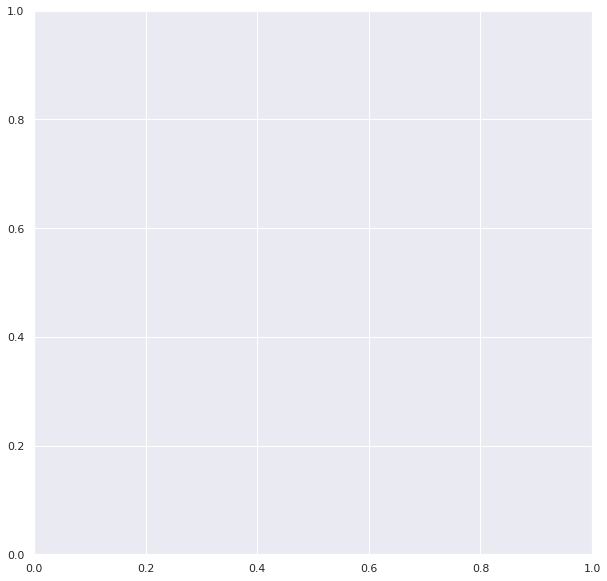

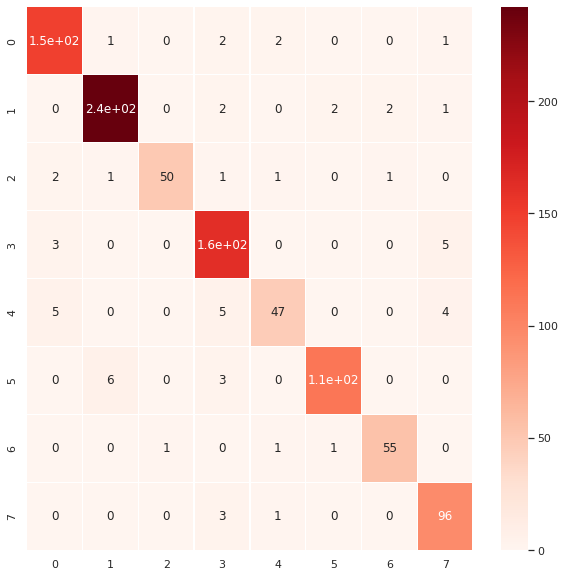

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)

cm = confusion_matrix(f_y_test, f_pred_y,labels=new_classes)
ax = plt.subplots(figsize=(10,10)) 
#sns.heatmap(cm, annot=True,cmap="Blues",xticklabels='auto')
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(cm, annot=True, linewidths=.5, cmap="Reds",ax=ax)